In [1]:
import as_seg.scripts.default_path as paths
import as_seg.scripts.overall_scripts as scr
import as_seg.data_manipulation as dm
import as_seg.CBM_algorithm as CBM
import as_seg.autosimilarity_computation as as_comp
import as_seg.barwise_input as bi
from as_seg.model.current_plot import *

import math
import numpy as np
import pandas as pd
import mirdata
import os
import tensorly as tl

bands_numbers = [None,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]

In [2]:
def get_scores_from_autosimilarity_nopenalty(autosimilarity, bars, references_segments, bands_number = None):
    res = math.inf * np.ones((2, 3))
    segments = CBM.compute_cbm(autosimilarity, penalty_weight = 0, penalty_func = "modulo8", bands_number = bands_number)[0]                
    segments_in_time = dm.segments_from_bar_to_time(segments, bars)

    prec05, rap05, f_mes05 = dm.compute_score_of_segmentation(references_segments, segments_in_time, window_length = 0.5)
    res[0] = [round(prec05,4),round(rap05,4),round(f_mes05,4)]
    prec3, rap3, f_mes3 = dm.compute_score_of_segmentation(references_segments, segments_in_time, window_length = 3)
    res[1] = [round(prec3,4),round(rap3,4),round(f_mes3,4)]
    
    return res

In [3]:
def compute_diff_bands_kernels_nopen(feature, bands_numbers):
    songs_range = range(1,101) # All the dataset
    subdivision = 96
    hop_length = 32
    hop_length_seconds = hop_length/44100
    autosimilarity_types = ["cosine", "covariance", "rbf"]

    results_diff_as = math.inf * np.ones((len(songs_range), len(bands_numbers), 3, 2, 3)) # Songs, bands, autosimilarity types, tol, metrics

    for idx_song, song_name in enumerate(songs_range):
        spectrogram, bars, references_segments = scr.load_spec_annot_song_RWC(song_name, feature, hop_length)
        freq_len = spectrogram.shape[0]
        barwise_TF_matrix = bi.barwise_TF_matrix(spectrogram, bars, hop_length_seconds, subdivision)

        # Cosine Autosimilarity
        autosimilarity_barTF_matrix = as_comp.switch_autosimilarity(barwise_TF_matrix, similarity_type = "cosine", normalise = True)
        for idx, bands_number in enumerate(bands_numbers):
            results_diff_as[idx_song, idx, 0] = get_scores_from_autosimilarity_nopenalty(autosimilarity_barTF_matrix, bars, references_segments, bands_number = bands_number)
        # Covariance Autosimilarity
        autosimilarity_barTF_matrix = as_comp.switch_autosimilarity(barwise_TF_matrix, similarity_type = "covariance", normalise = True)
        for idx, bands_number in enumerate(bands_numbers):
            results_diff_as[idx_song, idx, 1] = get_scores_from_autosimilarity_nopenalty(autosimilarity_barTF_matrix, bars, references_segments, bands_number = bands_number)
        # RBF Autosimilarity
        autosimilarity_barTF_matrix = as_comp.switch_autosimilarity(barwise_TF_matrix, similarity_type = "rbf", normalise = True)
        for idx, bands_number in enumerate(bands_numbers):
            results_diff_as[idx_song, idx, 2] = get_scores_from_autosimilarity_nopenalty(autosimilarity_barTF_matrix, bars, references_segments, bands_number = bands_number)

    all_avg_res = []
    indexes = []
    indexes_as = []
    indexes_bn = []
    for idx_as, current_as in enumerate(autosimilarity_types):
        for idx_bn, bands_number in enumerate(bands_numbers):
            line = []
            for tol in range(2):
                for metric in range(3):
                    line.append(np.mean(results_diff_as[:,idx_bn, idx_as, tol, metric]))
            indexes_as.append(f"Autosimilarity: {current_as}")
            indexes_bn.append(f"Bands number: {bands_number}")
            all_avg_res.append(line) 

    indexes = [np.array(indexes_as), np.array(indexes_bn)]
    np_all_avg_res = np.array(all_avg_res)
    dataframe = pd.DataFrame(np_all_avg_res, columns = ['P0.5', 'R0.5', 'F0.5','P3', 'R3', 'F3'], index = indexes)
    display(dataframe.style.bar(subset=["F0.5","F3"], color='#5fba7d'))

    return results_diff_as

In [4]:
def fixed_condition_lengths_rwc(feature, bands_number, autosimilarity_type, penalty = False, penalty_func = "modulo8"):
    songs_range = range(1,101) # All the dataset
    lengths = []
    subdivision = 96
    hop_length = 32
    hop_length_seconds = hop_length/44100

    lengths = []
        
    for idx_song, song_name in enumerate(songs_range):
        spectrogram, bars, references_segments = scr.load_spec_annot_song_RWC(song_name, feature, hop_length)
        freq_len = spectrogram.shape[0]
        barwise_TF_matrix = bi.barwise_TF_matrix(spectrogram, bars, hop_length_seconds, subdivision)
        autosimilarity_barTF_matrix = as_comp.switch_autosimilarity(barwise_TF_matrix, similarity_type = autosimilarity_type, normalise = True)
        
        if penalty:
            penalty_weight = 1
        else:
            penalty_weight = 0
        segments = CBM.compute_cbm(autosimilarity_barTF_matrix, penalty_weight = penalty_weight, penalty_func = penalty_func, bands_number = bands_number)[0]                

        for end, start in segments:
            lengths.append(start - end)

    plot_lenghts_hist(lengths)
    return lengths

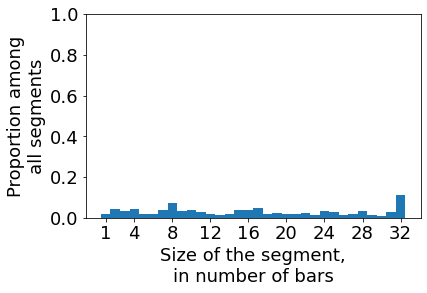

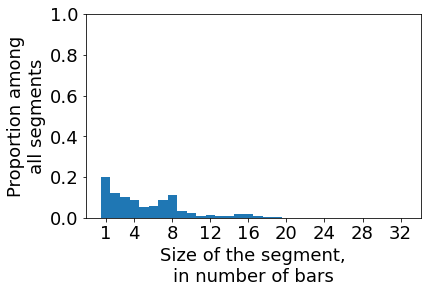

In [5]:
_ = fixed_condition_lengths_rwc("log_mel_grill", None, "cosine", penalty = False)
_ = fixed_condition_lengths_rwc("log_mel_grill", None, "covariance", penalty = False)

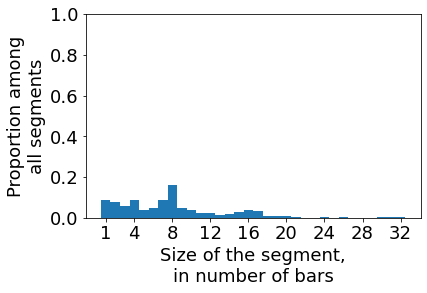

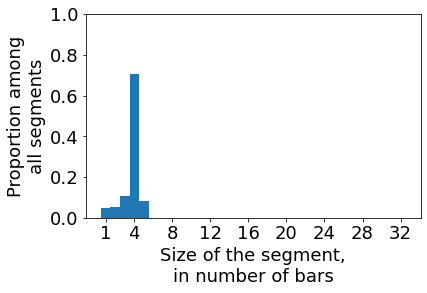

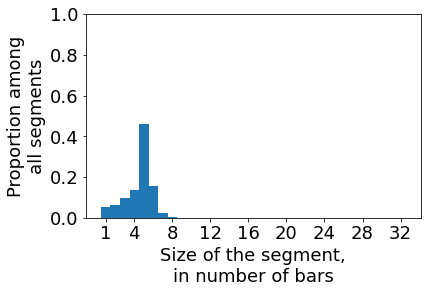

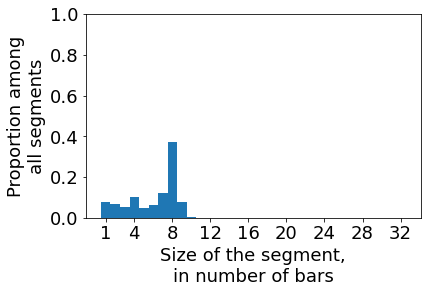

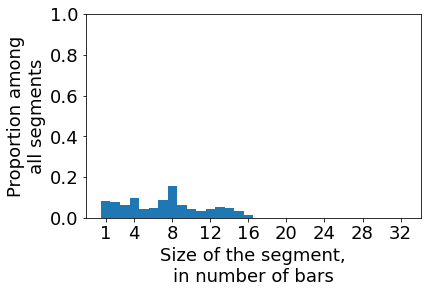

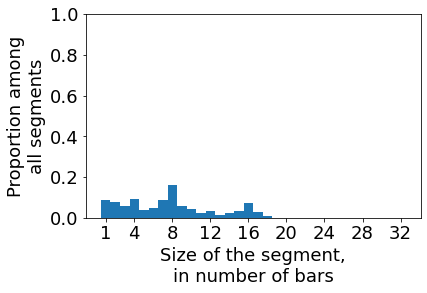

In [6]:
_ = fixed_condition_lengths_rwc("log_mel_grill", None, "rbf", penalty = False)
_ = fixed_condition_lengths_rwc("log_mel_grill", 3, "rbf", penalty = False)
_ = fixed_condition_lengths_rwc("log_mel_grill", 4, "rbf", penalty = False)
_ = fixed_condition_lengths_rwc("log_mel_grill", 7, "rbf", penalty = False)
_ = fixed_condition_lengths_rwc("log_mel_grill", 12, "rbf", penalty = False)
_ = fixed_condition_lengths_rwc("log_mel_grill", 15, "rbf", penalty = False)

In [4]:
# Log MEL
print("Log Mel")
_ = compute_diff_bands_kernels_nopen("log_mel_grill", bands_numbers = bands_numbers)
#_ = compute_diff_bands_kernels_nopen("log_mel_grill", bands_numbers = [None, 16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31])

Log Mel


In [ ]:
# RBF results in an histogram

colors = ['tab:green', 'tab:purple','tab:red','tab:olive']

bands_numbers_labels = ["Full", " ","1b","2b","3b","4b","5b","6b","7b","8b","9b","10b","11b","12b","13b","14b","15b","16b"]

plt.rcParams.update({'font.size': 17})

tol = 0
res_bands = np.array([[round(56.2466,2), round(71.8560,2)],
                      [0, 0],
[round(37.6237,2), round(48.2133,2)],
[round(39.7916,2), round(59.2825,2)],
[round(51.8937,2), round(65.3414,2)],
[round(44.7578,2), round(61.6879,2)],
[round(47.9342,2), round(66.3412,2)],
[round(56.8436,2), round(75.2490,2)],
[round(62.2846,2), round(79.4727,2)],
[round(56.8297,2), round(77.0183,2)],
[round(55.6897,2), round(73.1059,2)],
[round(55.9554,2), round(71.7119,2)],
[round(55.6421,2), round(71.2134,2)],
[round(55.4996,2), round(71.1541,2)],
[round(56.2412,2), round(71.9573,2)],
[round(57.6494,2), round(73.3429,2)],
[round(58.3729,2), round(73.7334,2)],
[round(57.5559,2) ,round(73.2373,2)]])

fig, ax = plt.subplots(1, 1, figsize=(11,4))
ax.set_ylim( 35, 100 )
ticks = [0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]

bars = ax.bar(bands_numbers_labels, res_bands[:,tol], color="#184a4a")
ax.set_xticks(ticks)
ax.tick_params(labelsize=14)
ax.set_xlabel("Kernel type")
ax.set_ylabel("F Measure")
#ax.set_title("F measure")

for idx_x, x in enumerate(bars):
    if idx_x != 1:
        height = x.get_height() #res_bands[idx_x, tol] 
        plt.text(idx_x,height + 2, f"{height}%", ha='center', va='bottom', rotation = 90)